In [164]:
import pandas as pd
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [165]:
# Plotly
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
init_notebook_mode()
import plotly_express as px

In [166]:
df = pd.read_csv('./cdf.csv')

In [167]:
df.set_index('Geography', inplace = True)

In [168]:
df.dtypes

avgAnnCount               float64
medIncome                   int64
popEst2015                  int64
povertyPercent            float64
studyPerCap               float64
MedianAge                 float64
MedianAgeMale             float64
MedianAgeFemale           float64
AvgHouseholdSize          float64
PercentMarried            float64
PctNoHS18_24              float64
PctHS18_24                float64
PctBachDeg18_24           float64
PctHS25_Over              float64
PctBachDeg25_Over         float64
PctEmployed16_Over        float64
PctUnemployed16_Over      float64
PctPrivateCoverage        float64
PctEmpPrivCoverage        float64
PctPublicCoverage         float64
PctPublicCoverageAlone    float64
PctWhite                  float64
PctBlack                  float64
PctAsian                  float64
PctOtherRace              float64
PctMarriedHouseholds      float64
BirthRate                 float64
dtype: object

Once we set the county name as the index all our columns are numerical so there is no need to create dummy variables.
We will, however, need to split our data and standardize.

In [169]:
X = df.drop(columns='avgAnnCount')
y = df.avgAnnCount

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, test_size=0.2, 
                                                    random_state=22)

In [170]:
pipe = make_pipeline(
        StandardScaler(),
        SelectKBest(f_regression),
        LinearRegression()
)

In [171]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000002CD248FB670>)),
                ('linearregression', LinearRegression())])

In [172]:
pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('selectkbest',
   SelectKBest(score_func=<function f_regression at 0x000002CD248FB670>)),
  ('linearregression', LinearRegression())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'selectkbest': SelectKBest(score_func=<function f_regression at 0x000002CD248FB670>),
 'linearregression': LinearRegression(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'selectkbest__k': 10,
 'selectkbest__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True)>,
 'linearregression__copy_X': True,
 'linearregression__fit_intercept': True,
 'linearregression__n_jobs': None,
 'linearregression__normalize': 'deprecated',
 'linearregression__positive': False}

In [173]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [174]:
print("The R score on the training data is:", r2_score(y_train, y_tr_pred))
print("The R score on the test data is:", r2_score(y_test, y_te_pred))

The R score on the training data is: 0.8742541156440051
The R score on the test data is: 0.8179126071349228


In [175]:
print("The Mean Squared Error on the training data is:", mean_squared_error(y_train, y_tr_pred))
print("The Mean Squared Error on the test data is:", mean_squared_error(y_test, y_te_pred))

The Mean Squared Error on the training data is: 265292.86971913854
The Mean Squared Error on the test data is: 289203.24121032987


In [176]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002CD248FB670>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26]})

In [177]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [178]:
lr_grid_cv.best_params_

{'selectkbest__k': 23}

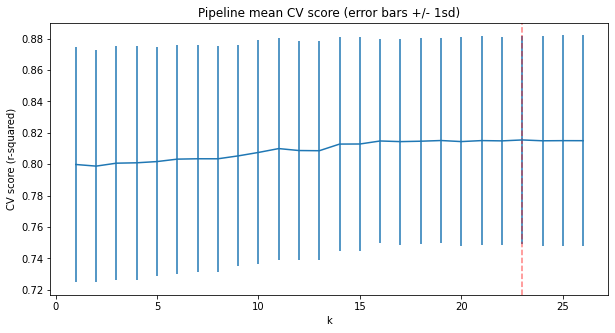

In [179]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [180]:
pipe_kbest = make_pipeline(
        StandardScaler(),
        SelectKBest(f_regression, k=23),
        LinearRegression()
)

pipe_kbest.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=23,
                             score_func=<function f_regression at 0x000002CD248FB670>)),
                ('linearregression', LinearRegression())])

In [181]:
kbest_y_tr_pred = pipe_kbest.predict(X_train)
kbest_y_te_pred = pipe_kbest.predict(X_test)

In [182]:
print("The R score on the training data is:", r2_score(y_train, kbest_y_tr_pred))
print("The R score on the test data is:", r2_score(y_test, kbest_y_te_pred))

The R score on the training data is: 0.8820989442366104
The R score on the test data is: 0.8311828829526589


In [183]:
print("The Mean Squared Error on the training data is:", mean_squared_error(y_train, kbest_y_tr_pred))
print("The Mean Squared Error on the test data is:", mean_squared_error(y_test, kbest_y_te_pred))

The Mean Squared Error on the training data is: 248742.21201415116
The Mean Squared Error on the test data is: 268126.511416697


In [184]:
pipe_kbest.score(X_train, y_train)

0.8820989442366104

In [185]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe_kbest, X, y, cv=5)
scores

array([0.80124148, 0.96468678, 0.72843703, 0.94397249, 0.49887564])

In [186]:
lr_model = LinearRegression()
fit_lr_model= lr_model.fit(X_train, y_train)
coeff = pd.DataFrame(fit_lr_model.coef_, X.columns, columns=['Coefficients'])
print(coeff)

                        Coefficients
medIncome                   0.003907
popEst2015                  0.004017
povertyPercent             -0.038961
studyPerCap                 0.043716
MedianAge                  -0.128398
MedianAgeMale              -6.451761
MedianAgeFemale            13.353615
AvgHouseholdSize           -1.082384
PercentMarried              6.414193
PctNoHS18_24                1.871499
PctHS18_24                 -3.230088
PctBachDeg18_24             0.776243
PctHS25_Over               -6.557684
PctBachDeg25_Over         -13.567487
PctEmployed16_Over         11.159371
PctUnemployed16_Over        1.413508
PctPrivateCoverage         19.560995
PctEmpPrivCoverage         -1.065245
PctPublicCoverage          11.972446
PctPublicCoverageAlone      9.912218
PctWhite                   -2.015731
PctBlack                   -2.264305
PctAsian                  -10.213506
PctOtherRace               -1.991562
PctMarriedHouseholds      -12.578836
BirthRate                  17.365232


In [187]:
descending_coeff = coeff.sort_values('Coefficients')
print(descending_coeff)

                        Coefficients
PctBachDeg25_Over         -13.567487
PctMarriedHouseholds      -12.578836
PctAsian                  -10.213506
PctHS25_Over               -6.557684
MedianAgeMale              -6.451761
PctHS18_24                 -3.230088
PctBlack                   -2.264305
PctWhite                   -2.015731
PctOtherRace               -1.991562
AvgHouseholdSize           -1.082384
PctEmpPrivCoverage         -1.065245
MedianAge                  -0.128398
povertyPercent             -0.038961
medIncome                   0.003907
popEst2015                  0.004017
studyPerCap                 0.043716
PctBachDeg18_24             0.776243
PctUnemployed16_Over        1.413508
PctNoHS18_24                1.871499
PercentMarried              6.414193
PctPublicCoverageAlone      9.912218
PctEmployed16_Over         11.159371
PctPublicCoverage          11.972446
MedianAgeFemale            13.353615
BirthRate                  17.365232
PctPrivateCoverage         19.560995


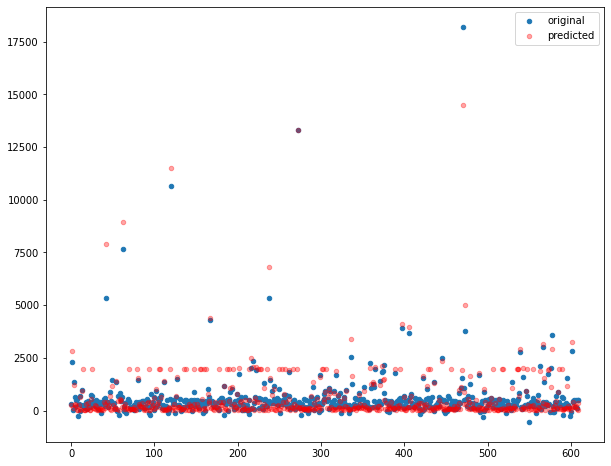

In [188]:
plt.figure(figsize = (10,8))

x_ax = range(len(y_test))
plt.scatter(x_ax, kbest_y_te_pred, s=20, label="original")
plt.scatter(x_ax, y_test, c='r', s =20, alpha = .35, label="predicted")
plt.legend()

In [189]:
linreg_df = pd.DataFrame(y_test)
linreg_df['Predictions'] = kbest_y_te_pred
linreg_df.head()

avgAnnCount  Predictions
Geography                                           
Greenup County, Kentucky          257.0   324.894654
Onondaga County, New York        2820.0  2297.969108
Worth County, Georgia             113.0    11.234838
Kalamazoo County, Michigan       1199.0  1370.505634
Laurens County, Georgia           253.0   185.969062

In [190]:
sorted_lr_df = linreg_df.sort_values('avgAnnCount', ascending=True)
sorted_lr_df.head()

avgAnnCount  Predictions
Geography                                              
Issaquena County, Mississippi          7.0  -120.725158
McCone County, Montana                 9.0   228.237603
Oldham County, Texas                  10.0   167.232540
Dickens County, Texas                 10.0   139.375900
Cheyenne County, Colorado             10.0    75.940443

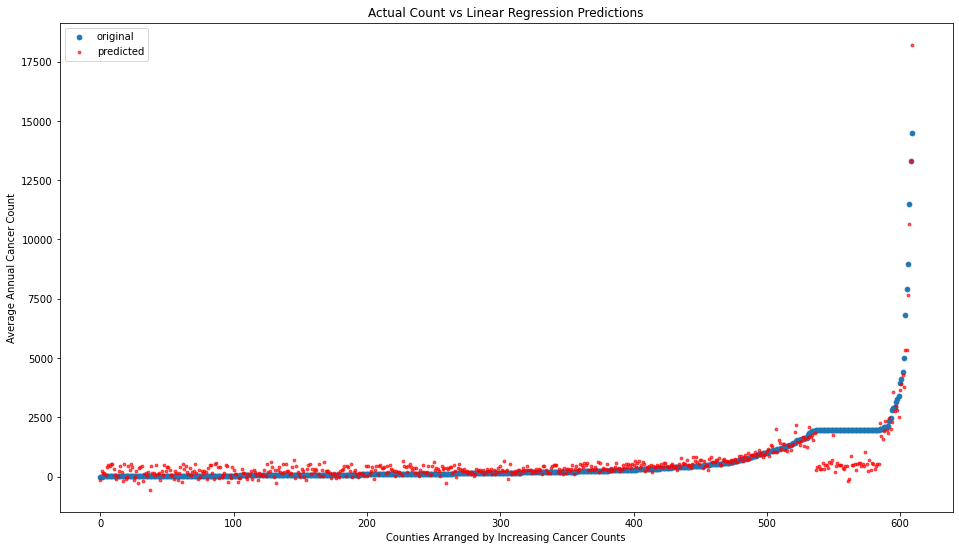

In [191]:
plt.figure(figsize = (16,9))

x_ax = range(len(y_test))
plt.scatter(x_ax, sorted_lr_df.avgAnnCount, s=22, label="original")
plt.scatter(x_ax, sorted_lr_df.Predictions, c='r', s =8, alpha = .65, label="predicted")
plt.xlabel('Counties Arranged by Increasing Cancer Counts')
plt.ylabel('Average Annual Cancer Count')
plt.title('Actual Count vs Linear Regression Predictions')
plt.legend();

## Random Forest

In [196]:
from sklearn.ensemble import RandomForestRegressor

In [200]:
parameters =  {
    "criterion": ["squared_error"],
    "n_estimators":[200, 400, 600],
    "max_depth":[7,9, 12],
    "min_samples_split": [1, 2, 3, 6]   
}

orf = GridSearchCV(RandomForestRegressor(), parameters, cv=5, n_jobs=-1, verbose=3)

orf.fit(X_train, y_train)
print(orf.score(X_train, y_train))
print(orf.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.9316209160367885
{'criterion': 'squared_error', 'max_depth': 9, 'min_samples_split': 3, 'n_estimators': 200}


In [201]:
rfpipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(criterion = 'squared_error', 
                          n_estimators = 200, 
                          max_features = 'sqrt', 
                          max_depth = 9, 
                          min_samples_split = 3, 
                          random_state = 18)
)

In [203]:
rfpipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=9, max_features='sqrt',
                                       min_samples_split=3, n_estimators=200,
                                       random_state=18))])

In [204]:
rf_ypred=rfpipe.predict(X_test)
mse = mean_squared_error(y_test, rf_ypred)
r2 = r2_score(y_test, rf_ypred)
print("Test Data MSE: %.2f" % mse)
print("Test Data R2: %.6f" % r2)

Test Data MSE: 427433.45
Test Data R2: 0.730880


## Gradient Boosting

In [57]:
GBpipeline = make_pipeline(
        StandardScaler(),
        GradientBoostingRegressor()
)

In [24]:
GradientBoostingRegressor().get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [58]:
parameters = {
    "learning_rate": [0.085, 0.1, 0.15],
    "max_depth":[2,3,6],
    "n_estimators":[100, 150, 400],
    "max_features":["log2","sqrt"],
    "min_samples_split": [2, 3, 6],
    }

clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=5, n_jobs=-1, verbose=10)

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
0.9425603578776919
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}


In [59]:
# Set lower and upper quantile
LOWER_ALPHA = 0.1

clf_lower = GridSearchCV(GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA), parameters, cv=5, n_jobs=-1, verbose=3)

clf_lower.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
0.9425603578776919
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}


In [60]:
UPPER_ALPHA = 0.9

clf_upper = GridSearchCV(GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA), parameters, cv=5, n_jobs=-1, verbose=3)

clf_upper.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
0.9425603578776919
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}


### Confirmed that the same parameters are best for lower and upper bound models

In [61]:
BestGBpipe = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(learning_rate = 0.1, max_depth = 3, max_features = 'sqrt', min_samples_split = 2, n_estimators = 150))

In [62]:
BestGBpipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_features='sqrt',
                                           n_estimators=150))])

In [96]:
ytr_pred=BestGBpipe.predict(X_train)
mse = mean_squared_error(ytr_pred,y_train)
r2 = r2_score(ytr_pred,y_train)
print("Training Data MSE: %.2f" % mse)
print("Training Data R2: %.6f" % r2)

ypred=BestGBpipe.predict(X_test)
mse = mean_squared_error(y_test, ypred)
r2 = r2_score(y_test, ypred)
print("Test Data MSE: %.2f" % mse)
print("Test Data R2: %.6f" % r2)

Training Data MSE: 120469.56
Training Data R2: 0.935922
Test Data MSE: 308833.44
Test Data R2: 0.805553


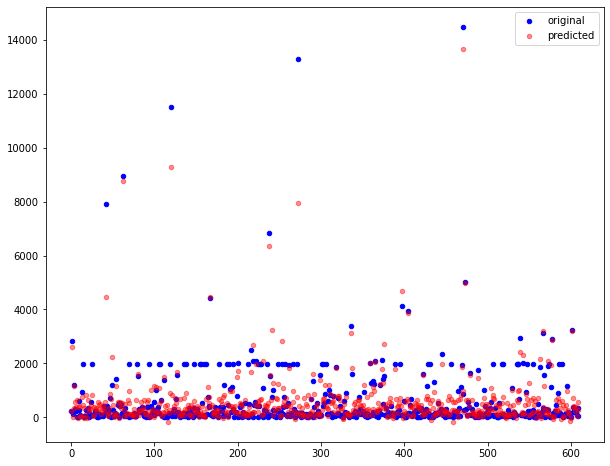

In [64]:
plt.figure(figsize = (10,8))


x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=20, color="blue", label="original")
plt.scatter(x_ax, ypred, s=20, color="red", label="predicted", alpha = .45)
plt.legend()
plt.show()

In [65]:
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9

# Each model has to be separate
lower_model_pipeline = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(learning_rate = 0.1, 
                                      max_depth = 3, 
                                      max_features = 'sqrt', 
                                      min_samples_split = 2, 
                                      n_estimators = 150,
                                        loss="quantile",                   
                                        alpha=LOWER_ALPHA)
)

upper_model_pipeline = make_pipeline(
    StandardScaler(), 
    GradientBoostingRegressor(loss="quantile", 
                                        learning_rate = 0.15, 
                                        max_depth = 3,
                                        max_features = 'log2', 
                                        min_samples_split = 6, 
                                        n_estimators = 150,
                                        alpha=UPPER_ALPHA)
)


In [66]:
lower_model_pipeline.fit(X_train, y_train)
upper_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.15, loss='quantile',
                                           max_features='log2',
                                           min_samples_split=6,
                                           n_estimators=150))])

In [67]:
lower_pred = lower_model_pipeline.predict(X_test)
upper_pred = upper_model_pipeline.predict(X_test)

In [69]:
predictions = pd.DataFrame(y_test)
predictions['lower'] = lower_pred
predictions['mid'] = ypred
predictions['upper'] = upper_pred

predictions.tail()

avgAnnCount       lower         mid  \
Geography                                                             
Adams County, Mississippi             194.0  151.007335  239.120309   
Cass County, Michigan                 228.0  212.509248  369.716485   
Desha County, Arkansas                 73.0   57.256198   52.628386   
Pittsylvania County, Virginia         346.0  255.295133  294.049048   
Bottineau County, North Dakota         43.0   32.907023  555.700176   

                                      upper  
Geography                                    
Adams County, Mississippi       1088.598696  
Cass County, Michigan            852.580610  
Desha County, Arkansas           136.296757  
Pittsylvania County, Virginia    541.765708  
Bottineau County, North Dakota  1624.848244

In [70]:
sorted_predictions = predictions.sort_values('avgAnnCount', ascending=True)
sorted_predictions.head()

avgAnnCount      lower         mid        upper
Geography                                                                     
Issaquena County, Mississippi          7.0  14.879391   61.121528   238.544758
McCone County, Montana                 9.0  12.676540  144.501205  1397.359755
Oldham County, Texas                  10.0   1.625333  416.491564   549.715947
Dickens County, Texas                 10.0  15.669038   79.339410   250.433911
Cheyenne County, Colorado             10.0  25.435805  572.504855  1219.761960

In [71]:
sorted_predictions.tail()

avgAnnCount       lower           mid  \
Geography                                                               
Allegheny County, Pennsylvania       7913.0  770.192867   4469.356976   
Broward County, Florida              8954.0  765.932905   8746.477155   
Miami-Dade County, Florida          11495.0  766.327034   9276.558149   
San Diego County, California        13294.0  782.898397   7938.801096   
Harris County, Texas                14477.0  774.005672  13656.865074   

                                       upper  
Geography                                     
Allegheny County, Pennsylvania   5392.221232  
Broward County, Florida          6421.979286  
Miami-Dade County, Florida      12270.392652  
San Diego County, California    12751.011398  
Harris County, Texas            17515.914291

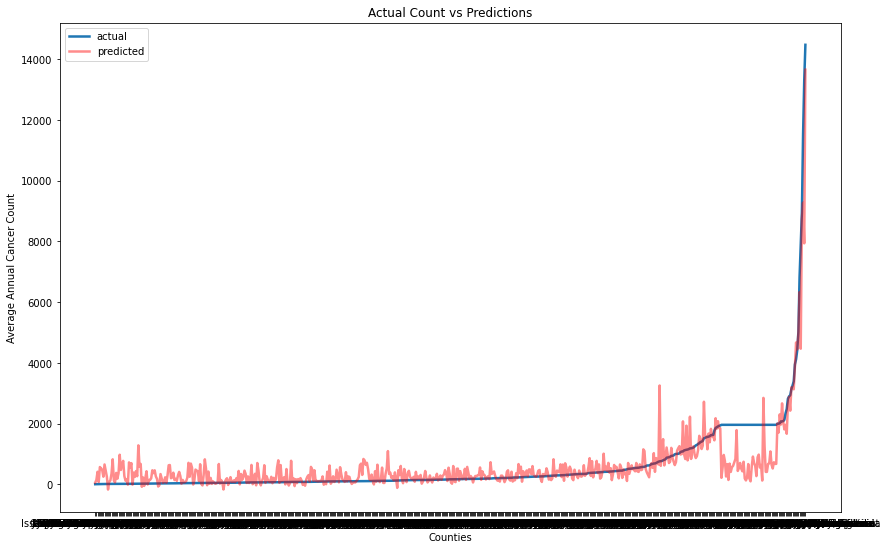

In [72]:
plt.figure(figsize = (14,9))

plt.plot(sorted_predictions.avgAnnCount, label = 'actual', linewidth = 2.5)
plt.plot(sorted_predictions.mid, color = 'red', alpha = .45, label='predicted', linewidth = 2.5)
plt.xlabel('Counties')
plt.ylabel('Average Annual Cancer Count')
plt.title('Actual Count vs Predictions')
plt.legend();

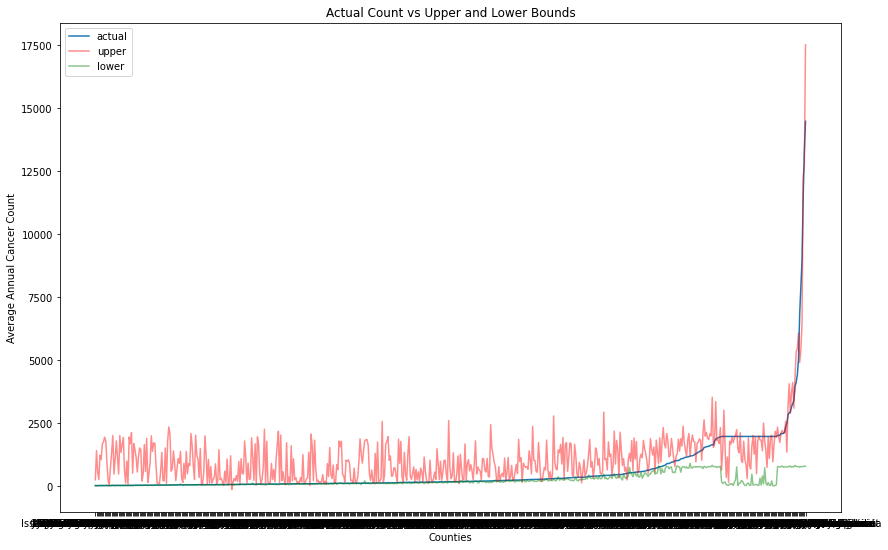

In [78]:
plt.figure(figsize = (14,9))

plt.plot(sorted_predictions.avgAnnCount, label = 'actual')
plt.plot(sorted_predictions.upper, color = 'red', alpha = .45, label='upper')
plt.plot(sorted_predictions.lower, color = 'green', alpha = .45, label='lower')
plt.xlabel('Counties')
plt.ylabel('Average Annual Cancer Count')
plt.title('Actual Count vs Upper and Lower Bounds')
plt.legend();

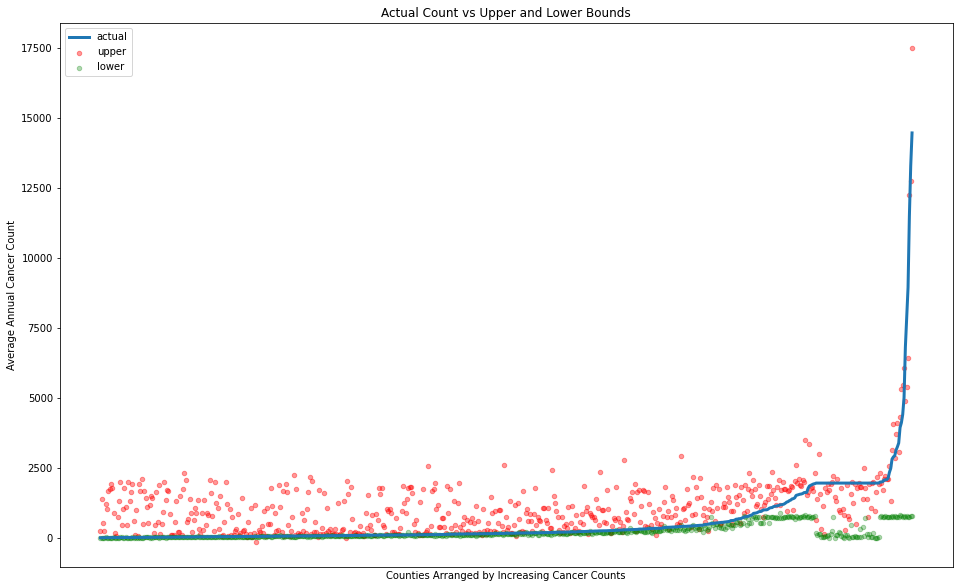

In [193]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize = (16,10))

x_ax = range(len(y_test))
plt.plot(sorted_predictions.avgAnnCount, label = 'actual', linewidth = 3)
plt.scatter(x_ax, sorted_predictions.upper, color = 'red', alpha = .40, label='upper', s=20)
plt.scatter(x_ax, sorted_predictions.lower, color = 'green', alpha = .30, label='lower', s=20)
plt.xlabel('Counties Arranged by Increasing Cancer Counts')
plt.ylabel('Average Annual Cancer Count')
plt.title('Actual Count vs Upper and Lower Bounds')
plt.xticks([])
plt.legend();

In [77]:
bottom_20 = sorted_predictions[:20]

In [195]:
bottom_20.describe()

avgAnnCount      lower         mid        upper
count    20.000000  20.000000   20.000000    20.000000
mean     13.700000  12.428935  294.512516  1070.882347
std       3.310271   7.860375  244.472789   631.219289
min       7.000000  -2.430007 -169.343425    60.096846
25%      10.750000   7.780383  116.289597   529.240070
50%      15.000000  13.287082  253.016145  1076.585199
75%      17.000000  17.600306  458.340087  1689.178428
max      18.000000  25.435805  827.089972  1997.899967

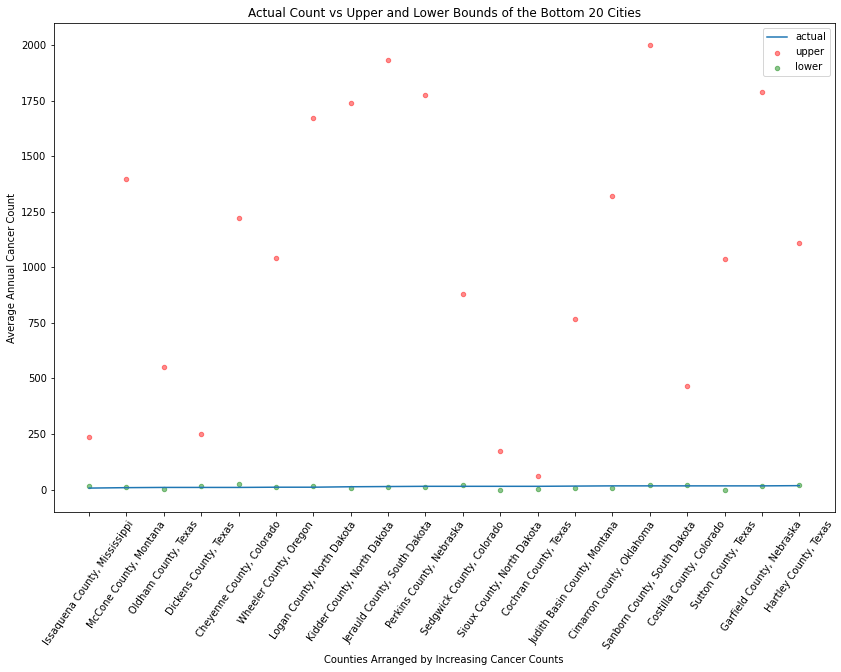

In [79]:
plt.figure(figsize = (14,9))

x_ax = range(20)
plt.plot(bottom_20.avgAnnCount, label = 'actual')
plt.scatter(x_ax, bottom_20.upper, color = 'red', alpha = .45, label='upper', s=20)
plt.scatter(x_ax, bottom_20.lower, color = 'green', alpha = .45, label='lower', s=20)
plt.xlabel('Counties Arranged by Increasing Cancer Counts')
plt.ylabel('Average Annual Cancer Count')
plt.title('Actual Count vs Upper and Lower Bounds of the Bottom 20 Cities')
plt.xticks(rotation=55)
plt.legend();


In [75]:
top_20 = sorted_predictions.tail(20)

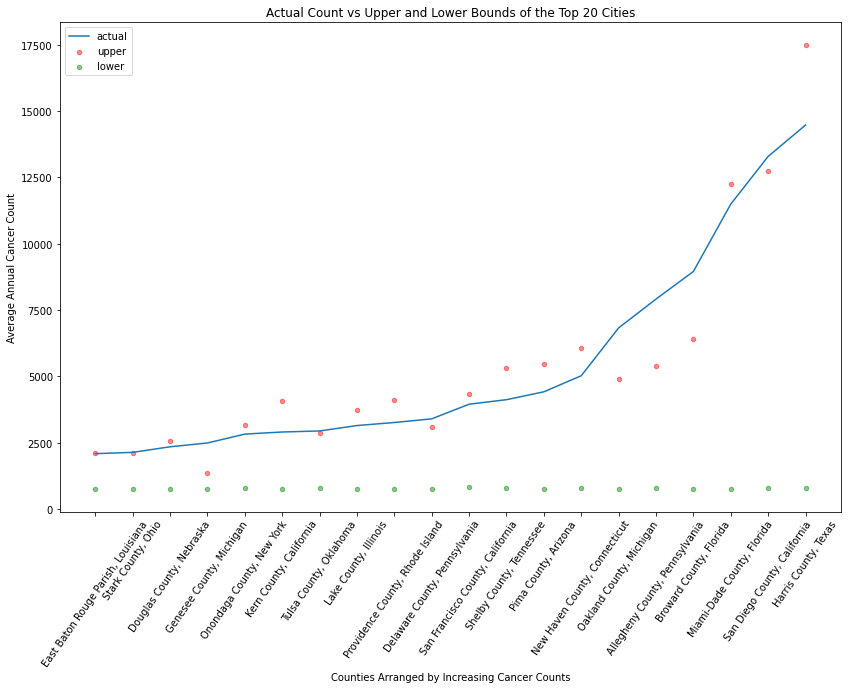

In [81]:
plt.figure(figsize = (14,9))

x_ax = range(20)
plt.plot(top_20.avgAnnCount, label = 'actual')
plt.scatter(x_ax, top_20.upper, color = 'red', alpha = .45, label='upper', s=20)
plt.scatter(x_ax, top_20.lower, color = 'green', alpha = .45, label='lower', s=20)
plt.xlabel('Counties Arranged by Increasing Cancer Counts')
plt.ylabel('Average Annual Cancer Count')
plt.title('Actual Count vs Upper and Lower Bounds of the Top 20 Cities')
plt.xticks(rotation=55)
plt.legend();

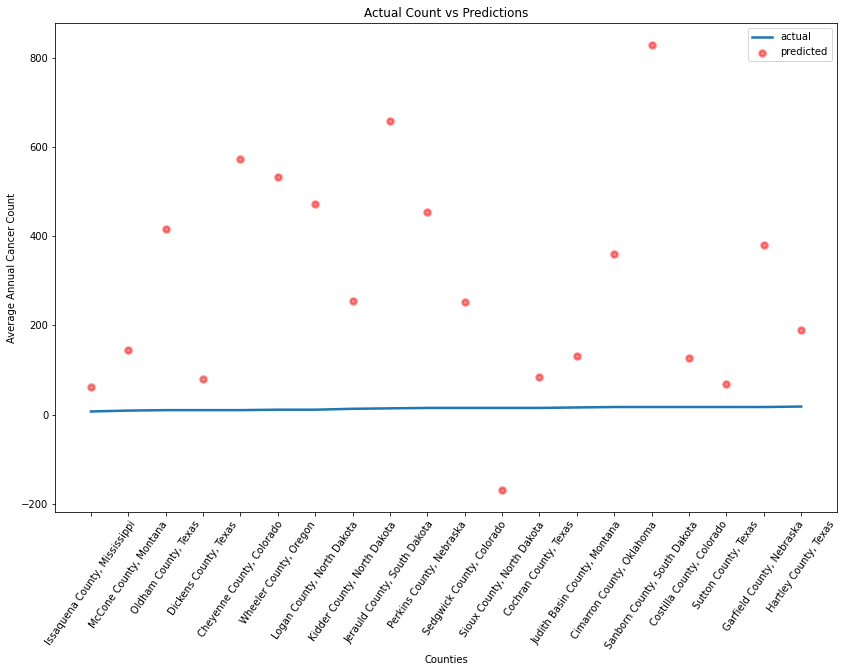

In [98]:
plt.figure(figsize = (14,9))

x_ax = range(20)
plt.plot(bottom_20.avgAnnCount, label = 'actual', linewidth = 2.5)
plt.scatter(x_ax, bottom_20.mid, color = 'red', alpha = .45, label='predicted', linewidth = 2.5)
plt.xlabel('Counties')
plt.ylabel('Average Annual Cancer Count')
plt.title('Actual Count vs Predictions')
plt.xticks(rotation=55)
plt.legend();

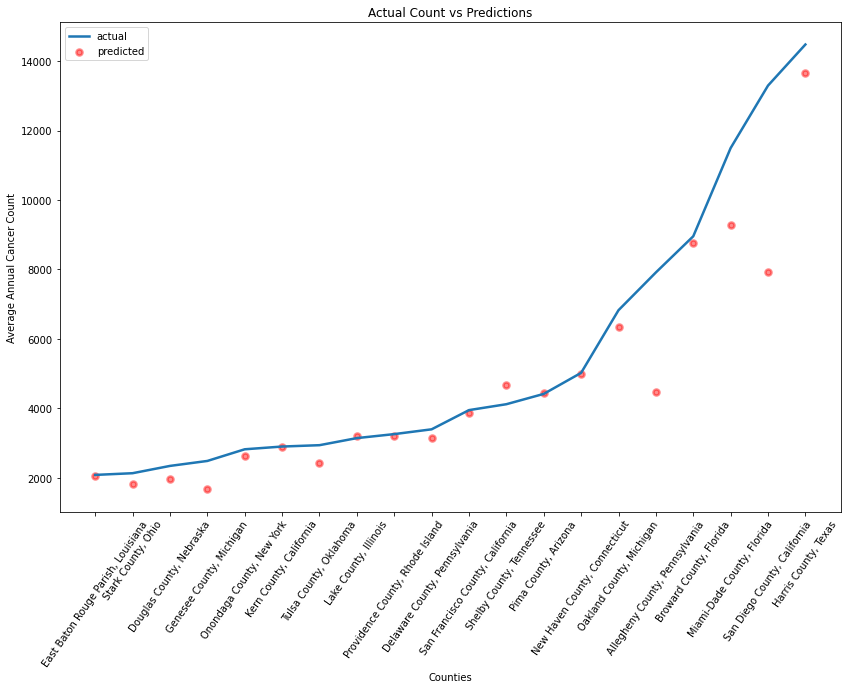

In [82]:
plt.figure(figsize = (14,9))

x_ax = range(20)
plt.plot(top_20.avgAnnCount, label = 'actual', linewidth = 2.5)
plt.scatter(x_ax, top_20.mid, color = 'red', alpha = .45, label='predicted', linewidth = 2.5)
plt.xlabel('Counties')
plt.ylabel('Average Annual Cancer Count')
plt.title('Actual Count vs Predictions')
plt.xticks(rotation=55)
plt.legend();

Our models seem to be fairly dialed in for most cases in the more average cases towards the middle of the graph, but have some puzzling results at the far ends. For example, three of our bottom 20 estimates are negative. On the other, our lower bound is nearly static around 4,000 even as our average cases nearly triple.

In [83]:
# Set lower and upper quantile
LOWER_ALPHA = 0.35
UPPER_ALPHA = 0.65

# Each model has to be separate
lower_model_pipeline2 = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(learning_rate = 0.15, 
                                        max_depth = 3, 
                                        max_features = 'log2', 
                                        min_samples_split = 6, 
                                        n_estimators = 150,
                                        loss="quantile",                   
                                        alpha=LOWER_ALPHA)
)

upper_model_pipeline2 = make_pipeline(
    StandardScaler(), 
    GradientBoostingRegressor(loss="quantile", 
                                        learning_rate = 0.15, 
                                        max_depth = 3,
                                        max_features = 'log2', 
                                        min_samples_split = 6, 
                                        n_estimators = 150,
                                        alpha=UPPER_ALPHA)
)


In [84]:
lower_model_pipeline2.fit(X_train, y_train)
upper_model_pipeline2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.65, learning_rate=0.15,
                                           loss='quantile', max_features='log2',
                                           min_samples_split=6,
                                           n_estimators=150))])

In [85]:
lower_pred2 = lower_model_pipeline2.predict(X_test)
upper_pred2 = upper_model_pipeline2.predict(X_test)

In [86]:
predictions2 = pd.DataFrame(y_test)
predictions2['lower'] = lower_pred2
predictions2['mid'] = ypred
predictions2['upper'] = upper_pred2

In [87]:
sorted_predictions2 = predictions2.sort_values('avgAnnCount', ascending=True)

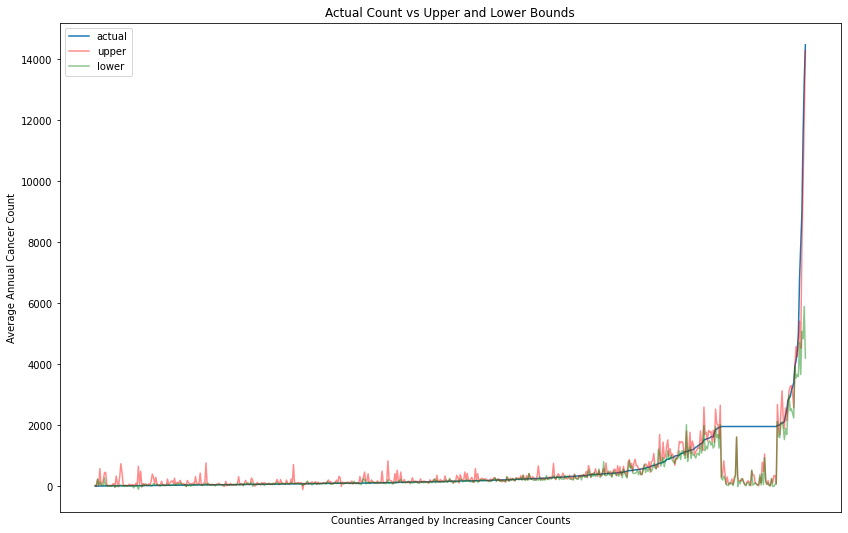

In [88]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize = (14,9))

plt.plot(sorted_predictions2.avgAnnCount, label = 'actual')
plt.plot(sorted_predictions2.upper, color = 'red', alpha = .45, label='upper')
plt.plot(sorted_predictions2.lower, color = 'green', alpha = .45, label='lower')
plt.xlabel('Counties Arranged by Increasing Cancer Counts')
plt.ylabel('Average Annual Cancer Count')
plt.title('Actual Count vs Upper and Lower Bounds')
plt.xticks([])
plt.legend();

In [90]:
def calculate_error(predictions):
    """
    Calculate the absolute error associated with prediction intervals
    
    :param predictions: dataframe of predictions
    :return: None, modifies the prediction dataframe
    
    """
    predictions['absolute_error_lower'] = (predictions['lower'] - predictions["avgAnnCount"]).abs()
    predictions['absolute_error_upper'] = (predictions['upper'] - predictions["avgAnnCount"]).abs()
    
    predictions['absolute_error_interval'] = (predictions['absolute_error_lower'] + predictions['absolute_error_upper']) / 2
    predictions['absolute_error_mid'] = (predictions['mid'] - predictions["avgAnnCount"]).abs()
    
    predictions['in_bounds'] = predictions["avgAnnCount"].between(left=predictions['lower'], right=predictions['upper'])

In [91]:
calculate_error(predictions)
metrics = predictions[['absolute_error_lower', 'absolute_error_upper', 'absolute_error_interval', 'absolute_error_mid', 'in_bounds']].copy()
metrics.describe()

absolute_error_lower  absolute_error_upper  absolute_error_interval  \
count            610.000000            610.000000               610.000000   
mean             380.658396            660.576426               520.617411   
std             1155.724933            603.437920               684.518879   
min                0.006521              0.095204                 3.031559   
25%                9.274639            146.324789               119.958509   
50%               27.928186            495.783359               385.488327   
75%              118.981579           1030.437011               713.512442   
max            13702.994328           3038.914291              8370.954309   

       absolute_error_mid  
count          610.000000  
mean           309.519007  
std            461.932058  
min              0.094214  
25%             61.029353  
50%            147.779648  
75%            354.656175  
max           5355.198904

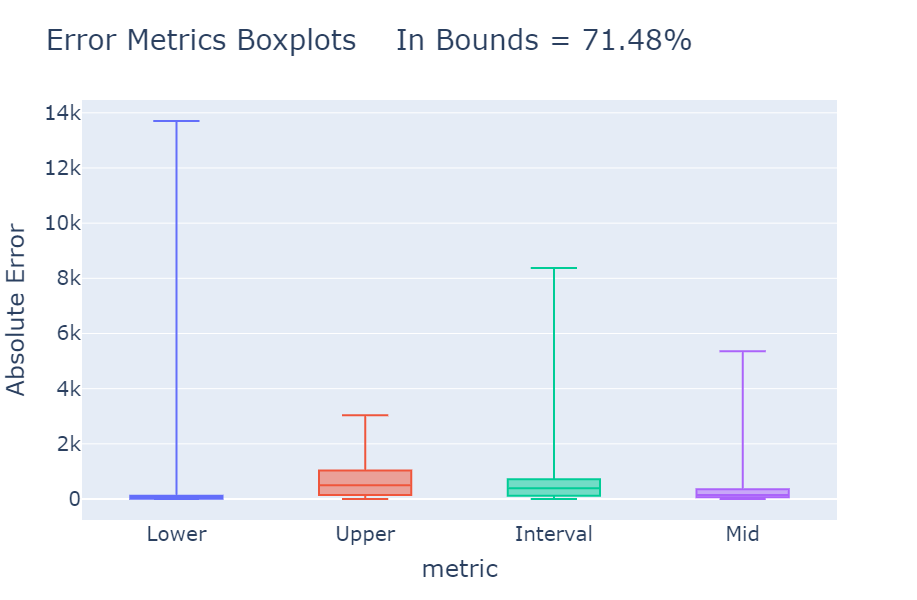

In [92]:
def show_metrics(metrics):
    """
    Make a boxplot of the metrics associated with prediction intervals
    
    :param metrics: dataframe of metrics produced from calculate error 
    :return fig: plotly figure
    """
    percent_in_bounds = metrics['in_bounds'].mean() * 100
    metrics_to_plot = metrics[[c for c in metrics if 'absolute_error' in c]]

    # Rename the columns
    metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

    # Create a boxplot of the metrics
    fig = px.box(
        metrics_to_plot.melt(var_name="metric", value_name='Absolute Error'),
        x="metric",
        y="Absolute Error",
        color='metric',
        title=f"Error Metrics Boxplots    In Bounds = {percent_in_bounds:.2f}%",
        height=600,
        width=800,
        points=False,
    )

    # Create new data with no legends
    d = []

    for trace in fig.data:
        # Remove legend for each trace
        trace['showlegend'] = False
        d.append(trace)

    # Make the plot look a little better
    fig.data = d
    fig['layout']['font'] = dict(size=20)
    return fig


iplot(show_metrics(metrics))

In [93]:
calculate_error(predictions2)
metrics2 = predictions2[['absolute_error_lower', 'absolute_error_upper', 'absolute_error_interval', 'absolute_error_mid', 'in_bounds']].copy()
metrics2.describe()

absolute_error_lower  absolute_error_upper  absolute_error_interval  \
count            610.000000            610.000000               610.000000   
mean             258.332073            241.995816               250.163945   
std              779.750128            486.059259               587.216434   
min                0.103887              0.013983                 1.028445   
25%               10.965500             19.214666                20.089787   
50%               26.827680             52.460672                43.741913   
75%               89.813339            180.004973               146.125778   
max            10268.694702           3381.277875              5231.343368   

       absolute_error_mid  
count          610.000000  
mean           309.519007  
std            461.932058  
min              0.094214  
25%             61.029353  
50%            147.779648  
75%            354.656175  
max           5355.198904

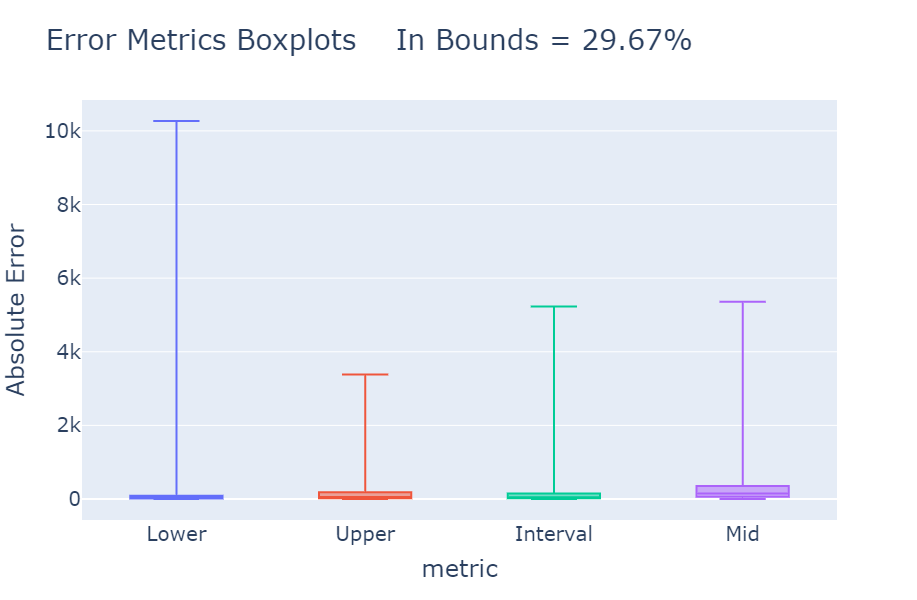

In [94]:
iplot(show_metrics(metrics2))

Our lower bound in particular is producing some large error metrics.

## Analysis

The simple linear regression model performed slightly better than the gradient boosting model. Mean Squared error was 268,127 for the Linear Regression model, compared to 308,833 for the gradient boosting model. In other words, the Linear Regression model puts us 40 diagnoses closer to the actual count. With both models, however, a majority of the error seems to be coming from a single segment of the data. The models track the initial rise from a couple hundred to about 1,800. There are swath of counties with cancer rates around 2,000 that both models predict to have extremely low diagnoses. Oddly, as the numbers start to increase above 2,000, both models once again begin tracking appropriately. If the appropriate resources were available, I would recommend isolating the counties the models are performing poorly on and seeing if they share some other trait or feature that we might be able to bring into the dataset to retrain the model.

The initial goal was to create a model that could flag unusually high or low numbers so that public health officials could get a head start on addressing environmental, behavioral, or other factors that could be causing cancer or causing cancer cases to go undiagnosed. For many of the counties in the middle range, the gradient boosting upper and lower bounds seem to be performing fairly well and might be used as good flag posts against which to judge. At the lower end, the upper bound looks to be significantly overestimating and at the higher end the lower bound gets less and less reliable. Therefore, it is worth considering whether to come up with an alterative marker for "too high" or "too low". This could be an amount outside of our error metric scaled to account for population, for example. Since our lower counties have avgAnnCounts around 10, being within 517 is not a sensible goal. Similarly, that may be too restrictive for a county with a population of several million.

Whatever process or metric is chosen to estimate upper and lower bounds at the far ends of avgAnnCount, it could be implemented either at only the low and high ends to aid the gradient boosting model, or across the board to replace it.

While not all of the model coefficients were obvious, unsurprisingly, insurance coverages - particularly private insurance -  were among the highest coefficients. Education levels were generally among the highest negative coefficients. These pieces of information alone might arm public health officials with powerful tools. As an example, a community with relatively low education levels will likely have less economic and political power to push back if an environmental hazard is discovered or intentionally placed near their neighborhood. Therefore, this information might be used to highlight vulnerable communities or push for legislative change to health care, so that if cancer rates are unusually high they are not going undiagnosed.